In [32]:
import requests
import pandas as pd
import os
import time
from dotenv import load_dotenv
import numpy as np

load_dotenv()
api_key = os.getenv('API_KEY')
email = os.getenv('EMAIL')

In [33]:
# we can change this to include more states or different pollutants as needed
target_states = ["06", "48", "36", "53", "42", "37"] 

# this can also be changed if we want more or less years of data
years = range(2018, 2024) 

# these are the pollutant codes we want to retrieve data for
params = "44201,42602,42101,81102,88101" 

# mapping pollutant codes to their names 
pollutant_map = {
    '44201': 'Ozone',
    '42602': 'NO2',
    '42101': 'CO',
    '81102': 'PM10',
    '88101': 'PM2.5'
}

In [34]:
all_data = []

for state in target_states:
    for year in years:
        # encodes the start and end dates
        bdate = f"{year}0101"
        edate = f"{year}1231"
        
        # api fetch
        url = (f"https://aqs.epa.gov/data/api/annualData/byState?"
               f"email={email}&key={api_key}&bdate={bdate}&edate={edate}"
               f"&param={params}&state={state}")
        
        # loop to get all the data based on the stuff we set in the last code chunk
        try:
            r = requests.get(url, timeout=10)
            if r.status_code == 200:
                data = r.json().get('Data', [])
                if data:
                    temp_df = pd.DataFrame(data)
                    all_data.append(temp_df)
            else:
                print(f"  > Error: State {state} | Year {year} | Status: {r.status_code}")
        except Exception as e:
            print(f"  > Failed: {e}")
        
        time.sleep(0.5)

  > Failed: HTTPSConnectionPool(host='aqs.epa.gov', port=443): Read timed out. (read timeout=10)


In [35]:
# combines all the data into one 
if all_data:
    df_raw = pd.concat(all_data, ignore_index=True)
    print(f"total rows: {len(df_raw)}")
    print(df_raw.columns.tolist())

total rows: 39359
['state_code', 'county_code', 'site_number', 'parameter_code', 'poc', 'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code', 'sample_duration', 'pollutant_standard', 'metric_used', 'method', 'year', 'units_of_measure', 'event_type', 'observation_count', 'observation_percent', 'validity_indicator', 'valid_day_count', 'required_day_count', 'exceptional_data_count', 'null_observation_count', 'primary_exceedance_count', 'secondary_exceedance_count', 'certification_indicator', 'arithmetic_mean', 'standard_deviation', 'first_max_value', 'first_max_datetime', 'second_max_value', 'second_max_datetime', 'third_max_value', 'third_max_datetime', 'fourth_max_value', 'fourth_max_datetime', 'first_max_nonoverlap_value', 'first_max_n_o_datetime', 'second_max_nonoverlap_value', 'second_max_n_o_datetime', 'ninety_ninth_percentile', 'ninety_eighth_percentile', 'ninety_fifth_percentile', 'ninetieth_percentile', 'seventy_fifth_percentile', 'fiftieth_percentile', 'tenth_pe

In [36]:
cols_to_keep = ['state_code', 'county_code', 'year', 'parameter_code', 'first_max_value', 'arithmetic_mean', 'observation_count', 'primary_exceedance_count', 'ninetieth_percentile']

df_clean = df_raw[cols_to_keep].copy()

df_clean['County_ID'] = df_clean['state_code'] + "_" + df_clean['county_code']
df_clean['Pollutant'] = df_clean['parameter_code'].map(pollutant_map)

df_clean['primary_exceedance_count'] = df_clean['primary_exceedance_count'].fillna(0)
df_clean['Pct_Unhealthy'] = df_clean['primary_exceedance_count'] / df_clean['observation_count']

state_agg = df_clean.groupby(['state_code', 'year', 'Pollutant'])[['first_max_value', 'Pct_Unhealthy']].mean().reset_index()

df_clean = df_clean.sort_values(by=['County_ID', 'Pollutant', 'year'])

df_clean['Max_Last_Year'] = df_clean.groupby(['County_ID', 'Pollutant'])['first_max_value'].shift(1)

df_clean['Rolling_Avg_3Y'] = df_clean.groupby(['County_ID', 'Pollutant'])['first_max_value'].transform(lambda x: x.rolling(3).mean())

df_clean['Target_Next_Year'] = df_clean.groupby(['County_ID', 'Pollutant'])['first_max_value'].shift(-1)

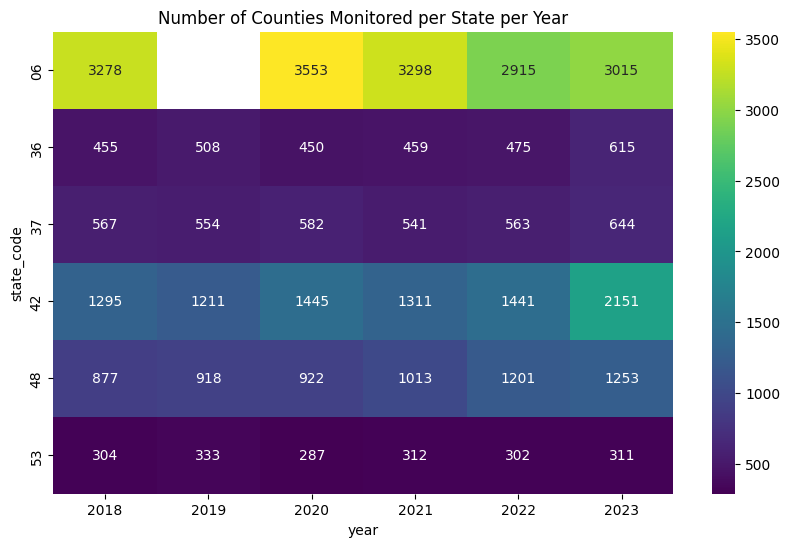

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

check_data = df_clean.groupby(['state_code', 'year']).size().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(check_data, annot=True, fmt='g', cmap='viridis')
plt.title("Number of Counties Monitored per State per Year")
plt.show()

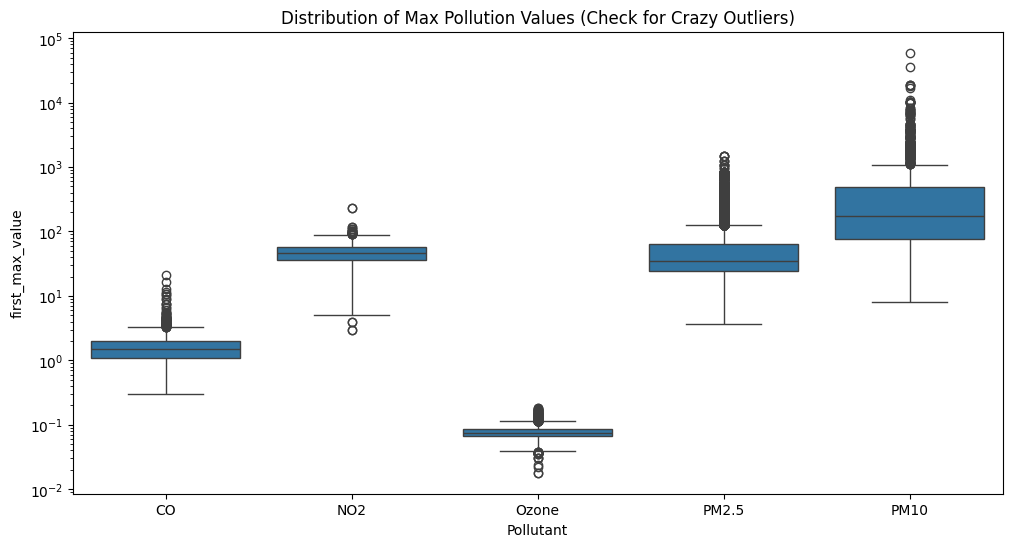

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='Pollutant', y='first_max_value')
plt.title("Distribution of Max Pollution Values (Check for Crazy Outliers)")
plt.yscale('log') 
plt.show()

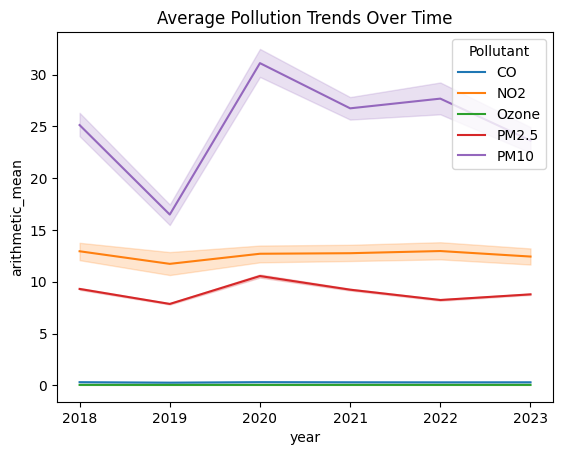

In [39]:
sns.lineplot(data=df_clean, x='year', y='arithmetic_mean', hue='Pollutant')
plt.title("Average Pollution Trends Over Time")
plt.show()

In [40]:
df_clean.to_csv('cleaned_aqi_data.csv', index=False)